In [2]:
import io
from IPython.nbformat import current
def execute_notebook(nbfile):
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    ip = get_ipython()
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
execute_notebook("/cellar/users/ramarty/Projects/hla_ii/bin/imports.ipynb")
execute_notebook("/cellar/users/ramarty/Projects/hla_ii/bin/samples.ipynb")

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


#### Establish available alleles

In [3]:
! /cellar/users/ramarty/programs/netMHCIIpan-3.1/netMHCIIpan -list > /cellar/users/ramarty/Data/hla_ii/presentation/other/netMHCIIpan_alleles.txt
netMHCIIpan_alleles = [x.strip() for x in open('/cellar/users/ramarty/Data/hla_ii/presentation/other/netMHCIIpan_alleles.txt').readlines()]

###HLAx

In [5]:
HLAx_results_path = '/cellar/users/ramarty/Data/hla_ii/hla_types/HLAx'
files = ['{0}/{1}'.format(HLAx_results_path, x) for x in os.listdir(HLAx_results_path) if x is not '_SUCCESS']
samples, alleles = [], []
for f in files:
    try:
        dictionary = json.loads(open(f).read())
        samples.append(dictionary['sample_id'])
        alleles.append(dictionary['hla']['alleles'])
    except:
        print f
patient_types_hlax = pd.DataFrame(alleles) 
patient_types_hlax.index = samples
patient_types_hlax = patient_types_hlax.ix[:,6:]
patient_types_hlax.columns = ['DPB1_allele1', 'DPB1_allele2', 'DQB1_allele1', 'DQB1_allele2',
                              'DRB1_allele1', 'DRB1_allele2']

In [8]:
# Update formatting to look like HLA-HD
def adjust_format(x):
    try:
        return ''.join([x.split('*')[0]] + x.split('*')[1].split(':'))
    except:
        return '-'
def adjust_format_DR(x):
    try:
        return '_'.join([x.split('*')[0]] + [''.join(x.split('*')[1].split(':'))])
    except:
        return '-'
patient_types_hlax['DPB1_allele1'] = patient_types_hlax['DPB1_allele1'].apply(adjust_format)
patient_types_hlax['DPB1_allele2'] = patient_types_hlax['DPB1_allele2'].apply(adjust_format)
patient_types_hlax['DQB1_allele1'] = patient_types_hlax['DQB1_allele1'].apply(adjust_format)
patient_types_hlax['DQB1_allele2'] = patient_types_hlax['DQB1_allele2'].apply(adjust_format)
patient_types_hlax['DRB1_allele1'] = patient_types_hlax['DRB1_allele1'].apply(adjust_format_DR)
patient_types_hlax['DRB1_allele2'] = patient_types_hlax['DRB1_allele2'].apply(adjust_format_DR)
patient_types_hlax = patient_types_hlax.replace('-', np.nan).dropna()
# convert to dictionary
patient_dict_hlax = patient_types_hlax.to_dict(orient='index')

Import HLA-HD results

In [11]:
patient_dict_hlahd = pickle.load(open('/cellar/users/ramarty/Data/hla_ii/hla_types/hla_types.tcga.p'))

In [12]:
patient_types_hlahd = pd.DataFrame(patient_dict_hlahd).transpose()
def strip_allele(x):
    return x.strip()
patient_types_hlahd.DPA1_allele2 = patient_types_hlahd.DPA1_allele2.apply(strip_allele)
patient_types_hlahd.DPB1_allele2 = patient_types_hlahd.DPB1_allele2.apply(strip_allele)
patient_types_hlahd.DQA1_allele2 = patient_types_hlahd.DQA1_allele2.apply(strip_allele)
patient_types_hlahd.DQB1_allele2 = patient_types_hlahd.DQB1_allele2.apply(strip_allele)
patient_types_hlahd.DRB1_allele2 = patient_types_hlahd.DRB1_allele2.apply(strip_allele)

In [13]:
patient_dict_hlahd = patient_types_hlahd.to_dict(orient='index')

In [14]:
hlahd_samples = patient_dict_hlahd.keys()

In [15]:
patient_dict_hlahd[hlahd_samples[0]]

{'DPA1_allele1': 'DPA10103',
 'DPA1_allele2': 'DPA10103',
 'DPB1_allele1': 'DPB10401',
 'DPB1_allele2': 'DPB110401',
 'DQA1_allele1': 'DQA10505',
 'DQA1_allele2': 'DQA10601',
 'DQB1_allele1': 'DQB10301',
 'DQB1_allele2': 'DQB10301',
 'DRB1_allele1': 'DRB1_1101',
 'DRB1_allele2': 'DRB1_1101'}

Compare the results for available genes

In [16]:
patient_dict_hlahd[samples[0]]

{'DPA1_allele1': 'DPA10103',
 'DPA1_allele2': 'DPA10103',
 'DPB1_allele1': 'DPB10402',
 'DPB1_allele2': 'DPB10201',
 'DQA1_allele1': 'DQA10301',
 'DQA1_allele2': 'DQA10103',
 'DQB1_allele1': 'DQB10603',
 'DQB1_allele2': 'DQB10302',
 'DRB1_allele1': 'DRB1_1301',
 'DRB1_allele2': 'DRB1_0407'}

In [17]:
# add a partial match
def check_compatability(x, y):
    if ((x[0] == y[0])&(x[1] == y[1])) | ((x[1] == y[0])&(x[0] == y[1])):
        return 'match'
    elif (x[0] == y[0])|(x[1] == y[1])|(x[0] == y[1])|(x[1] == y[0]):
        return 'partialmatch'
    else:
        return 'nomatch'

In [18]:
genes = []
match_codes = []
for gene in ['DRB1_allele', 'DPB1_allele', 'DQB1_allele']:
    matched, partialmatch, nomatched = 0, 0, 0
    for sample in [x for x in patient_dict_hlahd.keys() if x in patient_dict_hlax.keys()]:
        hd = patient_dict_hlahd[sample]
        x = patient_dict_hlax[sample]
        compatibility = check_compatability([x[gene+'1'], x[gene+'2']],
                               [hd[gene+'1'], hd[gene+'2']])
        if compatibility == 'match':
            matched += 1
        elif compatibility == 'partialmatch':
            partialmatch += 1
        else: 
            nomatched += 1
    print gene, matched, partialmatch, nomatched
    match_codes.append([matched, partialmatch, nomatched])
results_df = pd.DataFrame(match_codes)
results_df.index = ['DRB1', 'DPB1', 'DQB1']
results_df.columns = ['Both Alleles Match' , 'One Allele Matches', 'No Alleles Match']
results_df_long = results_df.stack().reset_index()
results_df_long.columns = ['Gene', 'Agreement', 'Patients']

DRB1_allele 7471 554 52
DPB1_allele 7225 640 212
DQB1_allele 7653 406 18


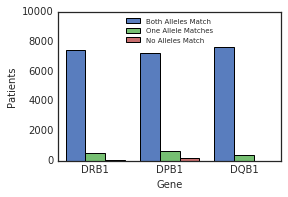

In [27]:
# Make figure 
plt.figure(figsize=(4, float(8)/3))
sns.barplot(x='Gene', y='Patients', hue='Agreement', data=results_df_long, palette=sns.color_palette("muted"))
plt.legend(loc=9, prop={'size': 7})
plt.ylim(0, 10000)
plt.savefig('/cellar/users/ramarty/Data/hla_ii/generated_figures/hla_typing/method_comparison.pdf',
           bbox_inches='tight')

####Output to a conservative and inclusive dataframe

Conservative

In [70]:
len(netMHCIIpan_alleles)

5622

In [67]:
conservative_patients = [x for x in patient_dict_hlahd.keys() if x in patient_dict_hlax.keys()]
print len(conservative_patients)

8077


In [22]:
conservative_dictionary = {}
for patient in conservative_patients:
    patient_dict = {}
    hd = patient_dict_hlahd[patient]
    x = patient_dict_hlax[patient]
    
    for gene in ['DRB1_allele', 'DPB1_allele', 'DQB1_allele']:
        # use HLA-HD unless they don't exist
        compatibility = check_compatability([x[gene+'1'], x[gene+'2']],
                                   [hd[gene+'1'], hd[gene+'2']])
        if compatibility == 'match':
            patient_dict[gene + '1'] = hd[gene+'1']
            patient_dict[gene + '2'] = hd[gene+'2']
    
    for gene in ['DPA1_allele', 'DQA1_allele']:
        if (hd[gene+'1'] != '-') & (hd[gene+'2'] != '-'):
            patient_dict[gene + '1'] = hd[gene+'1']
            patient_dict[gene + '2'] = hd[gene+'2']
        
    # Add to dictionary
    if len(patient_dict.keys()) == 10: # check
        conservative_dictionary[patient] = patient_dict

In [23]:
# convert to dataframe
conservative_df = pd.DataFrame(conservative_dictionary).transpose()
# output
print len(conservative_df)
conservative_df.to_csv('/cellar/users/ramarty/Data/hla_ii/hla_types/clean/TCGA.ClassII.conservative.csv')

6266


In [24]:
conservative_df.head()

,DPA1_allele1,DPA1_allele2,DPB1_allele1,DPB1_allele2,DQA1_allele1,DQA1_allele2,DQB1_allele1,DQB1_allele2,DRB1_allele1,DRB1_allele2
TCGA-02-0003,DPA10103,DPA10103,DPB10402,DPB10201,DQA10102,DQA10303,DQB10602,DQB10301,DRB1_1501,DRB1_0401
TCGA-02-0033,DPA10103,DPA10103,DPB10402,DPB10402,DQA10505,DQA10301,DQB10302,DQB10301,DRB1_1104,DRB1_0404
TCGA-02-0047,DPA10103,DPA10103,DPB10402,DPB11501,DQA10301,DQA10501,DQB10201,DQB10302,DRB1_0301,DRB1_0401
TCGA-02-0055,DPA10103,DPA10103,DPB10402,DPB10401,DQA10505,DQA10301,DQB10301,DQB10301,DRB1_1101,DRB1_0407
TCGA-02-2466,DPA10103,DPA10103,DPB10201,DPB10401,DQA10501,DQA10101,DQB10501,DQB10201,DRB1_0301,DRB1_0101


Inclusive

In [28]:
all_patients = list(set(patient_dict_hlahd.keys() + patient_dict_hlax.keys()))

In [29]:
inclusive_dictionary = {}
for patient in all_patients:
    patient_dict = {}
    if patient in patient_dict_hlahd.keys():
        hd = patient_dict_hlahd[patient]
    if patient in patient_dict_hlax.keys():
        x = patient_dict_hlax[patient]
    
    for gene in ['DRB1_allele', 'DPB1_allele', 'DQB1_allele']:
        # use HLA-HD unless they don't exist
        if (hd[gene+'1'] != '-') & (hd[gene+'2'] != '-'):
            patient_dict[gene + '1'] = hd[gene+'1']
            patient_dict[gene + '2'] = hd[gene+'2']
        else:
            patient_dict[gene + '1'] = x[gene+'1']
            patient_dict[gene + '2'] = x[gene+'2']
    
    for gene in ['DPA1_allele', 'DQA1_allele']:
        if (hd[gene+'1'] != '-') & (hd[gene+'2'] != '-'):
            patient_dict[gene + '1'] = hd[gene+'1']
            patient_dict[gene + '2'] = hd[gene+'2']
        
    # Add to dictionary
    if len(patient_dict.keys()) == 10: # check
        inclusive_dictionary[patient] = patient_dict

In [30]:
# convert to dataframe
inclusive_df = pd.DataFrame(inclusive_dictionary).transpose()
# output
print len(inclusive_df)
inclusive_df.to_csv('/cellar/users/ramarty/Data/hla_ii/hla_types/clean/TCGA.ClassII.inclusive.csv')

7965


In [44]:
inclusive_df.head()

,DPA1_allele1,DPA1_allele2,DPB1_allele1,DPB1_allele2,DQA1_allele1,DQA1_allele2,DQB1_allele1,DQB1_allele2,DRB1_allele1,DRB1_allele2
TCGA-02-0003,DPA10103,DPA10103,DPB10402,DPB10201,DQA10102,DQA10303,DQB10602,DQB10301,DRB1_1501,DRB1_0401
TCGA-02-0033,DPA10103,DPA10103,DPB10402,DPB10402,DQA10505,DQA10301,DQB10302,DQB10301,DRB1_1104,DRB1_0404
TCGA-02-0047,DPA10103,DPA10103,DPB10402,DPB11501,DQA10301,DQA10501,DQB10201,DQB10302,DRB1_0301,DRB1_0401
TCGA-02-0055,DPA10103,DPA10103,DPB10402,DPB10401,DQA10505,DQA10301,DQB10301,DQB10301,DRB1_1101,DRB1_0407
TCGA-02-2466,DPA10103,DPA10103,DPB10201,DPB10401,DQA10501,DQA10101,DQB10501,DQB10201,DRB1_0301,DRB1_0101


Also for both tools alone

In [60]:
patient_types_hlax.to_csv('/cellar/users/ramarty/Data/hla_ii/hla_types/clean/TCGA.ClassII.HLAx.csv')
print len(patient_dict_hlax)

8077


In [62]:
patient_types_hlahd = pd.DataFrame(patient_dict_hlahd).transpose()
def strip_allele(x):
    return x.strip()
patient_types_hlahd.DPA1_allele2 = patient_types_hlahd.DPA1_allele2.apply(strip_allele)
patient_types_hlahd.DPB1_allele2 = patient_types_hlahd.DPB1_allele2.apply(strip_allele)
patient_types_hlahd.DQA1_allele2 = patient_types_hlahd.DQA1_allele2.apply(strip_allele)
patient_types_hlahd.DQB1_allele2 = patient_types_hlahd.DQB1_allele2.apply(strip_allele)
patient_types_hlahd.DRB1_allele2 = patient_types_hlahd.DRB1_allele2.apply(strip_allele)
patient_types_hlahd = patient_types_hlahd.replace('-', np.nan).dropna()
patient_types_hlahd.to_csv('/cellar/users/ramarty/Data/hla_ii/hla_types/clean/TCGA.ClassII.HLA-HD.csv')
print len(patient_types_hlahd)

7929


##MHC-I

In [31]:
mhcI = pd.read_csv('/cellar/users/ramarty/Data/hla/git_data/data/hla_typing/hla_types.csv', index_col=0)

In [32]:
mhcI_typed_patients = list(mhcI.Sample)

In [33]:
len([x for x in inclusive_df.index if x not in mhcI_typed_patients])

232

In [34]:
with open('/cellar/users/ramarty/Data/hla_ii/hla_types/patients_needing_MHCI.txt', 'w') as f:
    for patient in [x for x in inclusive_df.index if x not in mhcI_typed_patients]:
        f.write('{0}\n'.format(patient))

Collect output and add to a complete dataframe/dictionary

In [35]:
barcodes = [x.strip() for x in open('/cellar/users/ramarty/Data/hla_ii/hla_types/patients_needing_MHCI.txt').readlines()]

In [36]:
alleles = []
for barcode in barcodes:
    try:
        alleles.append(open('/cellar/users/ramarty/Data/hla_ii/hla_types/Optitype/{0}/result.tsv'.format(barcode)).readlines()[1].split('\t')[1:-2])
    except:
        print barcode

TCGA-13-0766


In [38]:
# need this patient typed for it to work..  
#optitype_df = pd.DataFrame(alleles)
#optitype_df.index = barcodes

In [39]:
alleles = []
for barcode in barcodes:
    lines = open('/cellar/users/ramarty/Data/hla_ii/hla_types/Polysolver/{0}/winners.hla.txt'.format(barcode)).readlines()
    alleles_raw = []
    for i in range(3):
        alleles_raw.extend([x.strip() for x in lines[i].split('\t')[1:]])
    alleles_formatted = []
    for allele in alleles_raw:
        alleles_formatted.append('{0}*{1}:{2}'.format(allele.split('_')[1].upper(), 
                                                      allele.split('_')[2], 
                                                      allele.split('_')[3]))
    alleles.append(alleles_formatted)

In [40]:
polysolver_df = pd.DataFrame(alleles)
polysolver_df.index = barcodes

In [41]:
polysolver_df.head()

,0,1,2,3,4,5
TCGA-04-1371,A*01:03,A*30:01,B*40:06,B*13:01,C*05:01,C*05:01
TCGA-06-0165,A*01:01,A*26:01,B*37:01,B*15:17,C*07:01,C*06:02
TCGA-06-0178,A*29:02,A*30:02,B*44:03,B*44:03,C*16:01,C*16:01
TCGA-09-2054,A*30:02,A*32:01,B*14:01,B*35:01,C*07:06,C*05:01
TCGA-10-0936,A*36:01,A*68:02,B*45:01,B*44:03,C*16:01,C*04:01


In [45]:
polysolver_df.columns = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']

Add to rest of HLA-I types and put in clean directory (same order as MHC-II?)

In [73]:
hlaI_types = pd.read_csv('/cellar/users/ramarty/Data/hla/git_data/data/hla_typing/hla_types.csv', index_col=0)
hlaI_types.index = list(hlaI_types['Sample'])

In [74]:
hlaI_types.head()

,A1,A2,B1,B2,C1,C2,Sample
TCGA-P5-A780,A*01:01,A*02:01,B*07:02,B*35:03,C*04:01,C*07:02,TCGA-P5-A780
TCGA-55-A494,A*02:01,A*24:02,B*15:01,B*57:01,C*03:03,C*07:01,TCGA-55-A494
TCGA-BR-8382,A*02:01,A*02:01,B*08:01,B*57:01,C*06:02,C*07:01,TCGA-BR-8382
TCGA-Z2-AA3S,A*02:01,A*02:01,B*07:04,B*52:01,C*07:02,C*12:02,TCGA-Z2-AA3S
TCGA-BR-6564,A*02:01,A*11:01,B*35:03,B*40:01,C*03:04,C*12:03,TCGA-BR-6564


In [75]:
all_hlaI = pd.concat([hlaI_types[['A1', 'A2', 'B1', 'B2', 'C1', 'C2']], polysolver_df])

In [76]:
len(all_hlaI), len(inclusive_df)

(9408, 7965)

In [77]:
# subset, order and output as inclusive MHC-II
all_hlaI = all_hlaI.ix[list(inclusive_df.index)]
print len(all_hlaI.dropna())
all_hlaI.to_csv('/cellar/users/ramarty/Data/hla_ii/hla_types/clean/TCGA.ClassI.inclusive.csv')

7965


In [78]:
# subset, order and output as conservative MHC-II
all_hlaI = all_hlaI.ix[list(conservative_df.index)]
print len(all_hlaI.dropna())
all_hlaI.to_csv('/cellar/users/ramarty/Data/hla_ii/hla_types/clean/TCGA.ClassI.conservative.csv')

6266


### HLA-HD

Comparing HLA-HD original run with HLA-HD run with hlax data

In [24]:
patient_dict_hlahd_hlax_data = pickle.load(open('/cellar/users/ramarty/Data/hla_ii/hla_types/hla_types.tcga._hlax_data.p'))

In [25]:
genes = []
match_codes = []
for gene in ['DRB1_allele', 'DPB1_allele', 'DQB1_allele']:
    matched, partialmatch, nomatched = 0, 0, 0
    for sample in [x for x in patient_dict_hlahd.keys() if x in patient_dict_hlahd_hlax_data.keys()]:
        hd = patient_dict_hlahd[sample]
        x = patient_dict_hlahd_hlax_data[sample]
        compatibility = check_compatability([x[gene+'1'], x[gene+'2']],
                               [hd[gene+'1'], hd[gene+'2']])
        if compatibility == 'match':
            matched += 1
        elif compatibility == 'partialmatch':
            partialmatch += 1
        else: 
            nomatched += 1
    print gene, matched, partialmatch, nomatched
    match_codes.append([matched, partialmatch, nomatched])
results_df = pd.DataFrame(match_codes)
results_df.index = ['DRB1', 'DPB1', 'DQB1']
results_df.columns = ['Both Alleles Match' , 'One Allele Matches', 'No Alleles Match']
results_df_long = results_df.stack().reset_index()
results_df_long.columns = ['Gene', 'Agreement', 'Patients']

DRB1_allele 7957 226 150
DPB1_allele 7829 205 299
DQB1_allele 8152 104 77


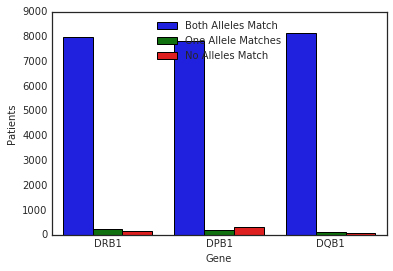

In [26]:
sns.barplot(x='Gene', y='Patients', hue='Agreement', data=results_df_long)
plt.legend(loc=9, prop={'size': 10})

In [ ]:
# Slightly different... let's go with the original for both